## Project Objective: 
Analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn.
### Key Business Requirements:

1. Churn to be identified for high value customers
2. We have 4 months of customer data.<br>
    a. Months 6,7 are known as good phase.<br>
    b. Month 8 is called as action phase.<br>
    c. Month 9 is called as the churn phase.
3. Using the 9th month data, we identify the customers as Churn (1) / No Churn (0) based on usage pattern.
4. Based on only 6,7 and 8th month data, we build a model that will predict the Churn identified in step 3 above.
5. The model should display good accuracy, recall and precision metrics.

## Solution Approach:

This is a typical imbalanced class problem where the churners are the minority class. Even after predicting everybody as a non-churner, we can still achieve an accuracy greater than 90%. Hence we need to build a model which is more focussed on predicting the churners. In this scenario Precision and Recall take more importance in arriving at the best model for prediction.<br>

The Threshold Probability for determining the Churn, can be set as per business requirements, to decide the appropriate balance between precision and recall. Our solution presents all the options that can be used to select an appropriate one.

### Part 1: Import Data and Data Manipulation
1. Read CSV file
2. Identify the Churn based on 9th month usage data and then drop all the 9th month data.
3. Drop columns with zero variance (unique values, static value and columns with all zeroes).
4. Retain only the high value customers, with recharge amount is in the top 70 percentile.
5. Drop columns which are sum of other columns (linear combinations of other columns).
6. Drop columns like arpu which have more than 50% null values and not usefull for churn prediction.
7. Impute Null Values.
8. Drop rows with null values in any of the columns which cannot be imputed.
9. Derive new features like Recency which are helpful in predicting churn.


### Part 2: Model Building - Logistic Regression
1. Split data into training and test sets and scale the data.
2. Variable Selection Using RFE / L1 regularization.
3. Model Training and Prediction.
4. Model Evaluation: Accuracy, Recall, Precision.
5. Model Evaluation: ROC.

### Part 3: Model Building - Logistic Regression with Cross Validation
1. Scale the data and do RFE.
2. Perform Logistic Regression with KFold Cross Validation.

### Part 4: Model Building - Logistic Regression with PCA
1. Plotting features in PrinComp Space.
2. Model Training and Prediction. 
3. Model Evaluation: Accuracy, Recall, Precision.

### Part 5: Model Building - SVM Linear with PCA
1. Model Training and Prediction.
2. Model Evaluation: Accuracy, Recall, Precision.

### Part 6: Model Building - SVM RBF with PCA with GridSearch
1. Model Training and Prediction.
2. Model Evaluation: CV Result Plots, Accuracy, Recall, Precision.

### Part 7: Conclusion Summary

### Part 1: Importing and Data Manipulation

In [1]:
# Importing Pandas and NumPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Entire notebook takes around 20 mins to complete.
import datetime
datetime.datetime.now()

datetime.datetime(2018, 12, 23, 17, 26, 10, 611785)

### 1.1 Read CSV file

In [3]:
# Importing all datasets
df = pd.read_csv("telecom_churn_data.csv",  sep=",",  encoding = "ISO-8859-1")

pd.options.display.max_columns = None

In [4]:
df.shape

(99999, 226)

In [5]:
df.head(10)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,

In [6]:
df.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.0,96140.0,94621.0,92254.0,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621

### 1.2 Churn is set to 1 or 0 based on 9th month usage
After this delete all the 55 columns related to the 9th month.

In [7]:
df['churn'] = np.where(((df.total_ic_mou_9 <= 0) & 
                (df.total_og_mou_9 <= 0) & 
                (df.vol_2g_mb_9 <= 0) & 
                (df.vol_3g_mb_9 <= 0)),1,0)

In [8]:
#verify sample churn values
print(df.loc[df.total_ic_mou_9 > 0,'churn'].head(5))
print(df.loc[df.total_og_mou_9 > 0,'churn'].head(5))
print(df.loc[df.vol_2g_mb_9 > 0,'churn'].head(5))
print(df.loc[df.vol_3g_mb_9 > 0,'churn'].head(5))

1    0
2    0
3    0
4    0
5    0
Name: churn, dtype: int32
1    0
2    0
3    0
4    0
5    0
Name: churn, dtype: int32
10    0
23    0
26    0
33    0
34    0
Name: churn, dtype: int32
2     0
23    0
33    0
40    0
44    0
Name: churn, dtype: int32


In [9]:
Ninthmonthcols = [col for col in df.columns if '_9' in col]

In [10]:
len(Ninthmonthcols)

54

In [11]:
df01 = df[df.columns[~df.columns.isin(Ninthmonthcols)]]
df01 = df01.drop('sep_vbc_3g', axis=1)

In [12]:
df01.shape

(99999, 172)

In [13]:
df01['loc_og_t2o_mou'].unique()

array([ 0., nan])

### 1.3 Drop columns with zero variance (unique values, static value and columns with all zeroes).
Drop following columns:<br>
mobile_number: unique id not required for modelling<br>
circle_id, last_date_of_month_6, last_date_of_month_7, last_date_of_month_8: contain a single value for all rows<br>

Columns with only zero values:<br>
loc_og_t2o_mou, std_og_t2o_mou, loc_ic_t2o_mou<br>
std_og_t2c_mou_6, std_og_t2c_mou_7, std_og_t2c_mou_8<br>
std_ic_t2o_mou_6, std_ic_t2o_mou_7, std_ic_t2o_mou_8<br>

In [14]:
df02 = df01.drop(['mobile_number', 'circle_id', 
                  'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                  'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
                  'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
                  'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8'], axis = 1)

In [15]:
df02.shape

(99999, 158)

### 1.4 Retain only the high value customers.
Customers with Average of total recharge amount of 6th and 7th month, in the top 70 percentile.

In [16]:
df02['Avgrechamt2mnths'] = np.round(df02[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1),2)

In [17]:
Avgrechamt = np.percentile(df02.Avgrechamt2mnths, 70)
Avgrechamt

368.5

In [18]:
df03 = df02.loc[df02['Avgrechamt2mnths'] > Avgrechamt]

In [19]:
df03.shape

(29979, 159)

Around 29.9k observations were retained as high value customers.

### 1.5 Drop columns which are linear combinations of other columns

** These columns are being dropped to avoid multi-collinearity issue, especially in logistic regression.**

Delete following 3x3 = 9 Summation OUTGOING MOU attributes:<br>
loc_og_mou_6<br>
std_og_mou_6<br>
total_og_mou_6<br>

loc_og_mou_6 = loc_og_t2t_mou_6 + loc_og_t2m_mou_6 + loc_og_t2f_mou_6 + loc_og_t2c_mou_6<br>
std_og_mou_6 = std_og_t2t_mou_6 + std_og_t2m_mou_6 + std_og_t2f_mou_6<br>
total_og_mou_6 = loc_og_mou_6 + std_og_mou_6 + isd_og_mou_6 + spl_og_mou_6 + og_others_6<br>

In [20]:
df04 = df03.drop(['loc_og_mou_6', 'std_og_mou_6', 'total_og_mou_6',
                  'loc_og_mou_7', 'std_og_mou_7', 'total_og_mou_7',
                  'loc_og_mou_8', 'std_og_mou_8', 'total_og_mou_8'], axis = 1)

Delete following 3x3=9 Summation INCOMING MOU attributes:<br>
loc_ic_mou_6<br>
std_ic_mou_6<br>
total_ic_mou_6<br>

loc_ic_mou_6 = loc_ic_t2t_mou_6 + loc_ic_t2m_mou_6 + loc_ic_t2f_mou_6<br>
std_ic_mou_6 = std_ic_t2t_mou_6 + std_ic_t2m_mou_6 + std_ic_t2f_mou_6<br>
total_ic_mou_6 = loc_ic_mou_6 + std_ic_mou_6 + spl_ic_mou_6 + isd_ic_mou_6 + ic_others_6<br>

In [21]:
df05 = df04.drop(['loc_ic_mou_6', 'std_ic_mou_6', 'total_ic_mou_6',
                  'loc_ic_mou_7', 'std_ic_mou_7', 'total_ic_mou_7',
                  'loc_ic_mou_8', 'std_ic_mou_8', 'total_ic_mou_8'], axis = 1)

### 1.6 Drop columns which have more than 50% null values and not usefull for churn prediction.

In [22]:
nullcolumns = df05.columns[np.round(df05.isnull().sum()/len(df05.index)*100,2) > 50]

In [23]:
#Verify the columns list which have null values in more than 50% of rows.
nullcolumns

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8'],
      dtype='object')

These below columns have Null values in more than 50% of rows and cannot be used for modeling, hence these are dropped:<br>
date_of_last_rech_data_6, date_of_last_rech_data_7, date_of_last_rech_data_8<br>

Below columns appear to be operator defined variables and cannot be imputed from other columns and have Null values in more than 50% of rows and cannot be used for modeling, hence these are dropped<br>
arpu_3g_6, arpu_3g_7,  arpu_3g_8<br>
arpu_2g_6, arpu_2g_7, arpu_2g_8<br>

In [24]:
df06 = df05.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
                 'date_of_last_rech_data_8', 'arpu_3g_6', 'arpu_3g_7',
                 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'], axis = 1)

In [25]:
#After deletion of the above columns, the below columns have being identified for Null value imputation.
df06.columns[np.round(df06.isnull().sum()/len(df06.index)*100,2) > 50]

Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'fb_user_6',
       'fb_user_7', 'fb_user_8'],
      dtype='object')

In [26]:
df06.head(5)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.0,0.00,0.00,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,1,1185.0
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,NaN,2.0,3.0,NaN,154.0,23.0,NaN,2.0,3.0,NaN,0.0,0.0,NaN,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,NaN,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,NaN,1.0,1.0,315,21.03,910.65,122.16,0,519.0
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,NaN,NaN,3.0,NaN,NaN,23.0,NaN,NaN,3.0,NaN,NaN,0.0,NaN,NaN,69.0,0.0,0.0,0.02,0.0,0.00,0.00,NaN,NaN,0.0,0,0,0,0,0,3,0,0,0,0,0,0,NaN,NaN,1.0,2607,0.00,0.00,0.00,0,380.0
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.8

In [27]:
df06.shape

(29979, 132)

### 1.7 Impute Null Values.

In [28]:
#Churn percentage before imputation: 8.64%
np.float32(df06.churn.sum()* 100)/(len(df06))  

8.636045231662164

In [29]:
#List of columns which contain null values: Before Null Value Imputation

df06.columns[np.round(df06.isnull().sum()/len(df06.index)*100,2) > 1]

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8',
       'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8',
       'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'spl_og_mou_6',
       'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6', 'og_others_7',
       'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',

In [30]:
#1.7.1 : If total recharge amount = 0, then all MOU usage columns are set to zero, else the existing values are retained.

list61 = ['onnet_mou_6', 'offnet_mou_6', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 
          'loc_og_t2f_mou_6', 'loc_og_t2c_mou_6', 'std_og_t2t_mou_6', 'std_og_t2m_mou_6', 'std_og_t2f_mou_6', 
          'isd_og_mou_6', 'spl_og_mou_6', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_6', 
          'std_ic_t2t_mou_6', 'std_ic_t2m_mou_6', 'std_ic_t2f_mou_6', 'spl_ic_mou_6', 'isd_ic_mou_6',
          'og_others_6','ic_others_6']

list71 = ['onnet_mou_7', 'offnet_mou_7', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_t2t_mou_7', 'loc_og_t2m_mou_7', 
          'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'std_og_t2t_mou_7', 'std_og_t2m_mou_7', 'std_og_t2f_mou_7', 
          'isd_og_mou_7', 'spl_og_mou_7', 'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_7', 
          'std_ic_t2t_mou_7', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_7', 'spl_ic_mou_7', 'isd_ic_mou_7',
          'og_others_7','ic_others_7']

list81 = ['onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 
          'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 
          'isd_og_mou_8', 'spl_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 
          'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
          'og_others_8','ic_others_8']

for col in list61:
    df06[col] = np.where(df06.total_rech_amt_6 == 0,0,df06[col])

for col in list71:
    df06[col] = np.where(df06.total_rech_amt_7 == 0,0,df06[col])
    
for col in list81:
    df06[col] = np.where(df06.total_rech_amt_8 == 0,0,df06[col])    

In [31]:
#1.7.2: 
#if total_rech_amt_7 is 0, 
#then set date_of_last_rech_7 to the value of date_of_last_rech_6, else retain the existing value.
#if total_rech_amt_8 is 0, 
#then set date_of_last_rech_8 to the value of date_of_last_rech_7, else retain the existing value.

#These columns are used to calculate the Recency of Recharge in the steps ahead.

df06["date_of_last_rech_7"] = np.where(df06.total_rech_amt_7 == 0,df06.date_of_last_rech_6,df06.date_of_last_rech_7)
df06["date_of_last_rech_8"] = np.where(df06.total_rech_amt_8 == 0,df06.date_of_last_rech_7,df06.date_of_last_rech_8)

In [32]:
#1.7.3 FB user data imputation: if 2g and 3g data usage volume is zero, then FB user is set to N, else Y.

df06["new_fb_user_6"] = np.where((df06.vol_2g_mb_6 + df06.vol_3g_mb_6 == 0) & ((df06.fb_user_6 != 1) ),"N",df06.fb_user_6)
df06["new_fb_user_6"] = df06["new_fb_user_6"].replace({"1.0":"Y","0.0":"N"})

df06["new_fb_user_7"] = np.where((df06.vol_2g_mb_7 + df06.vol_3g_mb_7 == 0) & ((df06.fb_user_7 != 1) ),"N",df06.fb_user_7)
df06["new_fb_user_7"] = df06["new_fb_user_7"].replace({"1.0":"Y","0.0":"N"})

df06["new_fb_user_8"] = np.where((df06.vol_2g_mb_8 + df06.vol_3g_mb_8 == 0) & ((df06.fb_user_8 != 1) ),"N",df06.fb_user_8)
df06["new_fb_user_8"] = df06["new_fb_user_8"].replace({"1.0":"Y","0.0":"N"})

#the original FB user columns are dropped.
df07 = df06.drop(["fb_user_6","fb_user_7","fb_user_8"],axis=1)

In [33]:
#1.7.4 If (sum of 2g and 3g usage volume is zero) and (existing value of below columns is null): 
#the column value is set to zero, else existing value is retained.

df07["total_rech_data_6"] = np.where((df07.vol_2g_mb_6 + df07.vol_3g_mb_6 == 0) & np.isnan(df07.total_rech_data_6),0,df07.total_rech_data_6)
df07["total_rech_data_7"] = np.where((df07.vol_2g_mb_7 + df07.vol_3g_mb_7 == 0) & np.isnan(df07.total_rech_data_7),0,df07.total_rech_data_7)
df07["total_rech_data_8"] = np.where((df07.vol_2g_mb_8 + df07.vol_3g_mb_8 == 0) & np.isnan(df07.total_rech_data_8),0,df07.total_rech_data_8)

df07["max_rech_data_6"] = np.where((df07.vol_2g_mb_6 + df07.vol_3g_mb_6 == 0) & np.isnan(df07.max_rech_data_6),0,df07.max_rech_data_6)
df07["max_rech_data_7"] = np.where((df07.vol_2g_mb_7 + df07.vol_3g_mb_7 == 0) & np.isnan(df07.max_rech_data_7),0,df07.max_rech_data_7)
df07["max_rech_data_8"] = np.where((df07.vol_2g_mb_8 + df07.vol_3g_mb_8 == 0) & np.isnan(df07.max_rech_data_8),0,df07.max_rech_data_8)

df07["total_rech_data_6"] = np.where((df07.vol_2g_mb_6 + df07.vol_3g_mb_6 == 0) & np.isnan(df07.total_rech_data_6),0,df07.total_rech_data_6)
df07["total_rech_data_7"] = np.where((df07.vol_2g_mb_7 + df07.vol_3g_mb_7 == 0) & np.isnan(df07.total_rech_data_7),0,df07.total_rech_data_7)
df07["total_rech_data_8"] = np.where((df07.vol_2g_mb_8 + df07.vol_3g_mb_8 == 0) & np.isnan(df07.total_rech_data_8),0,df07.total_rech_data_8)

df07["count_rech_2g_6"] = np.where((df07.vol_2g_mb_6 == 0) & np.isnan(df07.count_rech_2g_6),0,df07.count_rech_2g_6)
df07["count_rech_2g_7"] = np.where((df07.vol_2g_mb_7 == 0) & np.isnan(df07.count_rech_2g_7),0,df07.count_rech_2g_7)
df07["count_rech_2g_8"] = np.where((df07.vol_2g_mb_8 == 0) & np.isnan(df07.count_rech_2g_8),0,df07.count_rech_2g_8)

df07["count_rech_3g_6"] = np.where((df07.vol_3g_mb_6 == 0) & np.isnan(df07.count_rech_3g_6),0,df07.count_rech_3g_6)
df07["count_rech_3g_7"] = np.where((df07.vol_3g_mb_7 == 0) & np.isnan(df07.count_rech_3g_7),0,df07.count_rech_3g_7)
df07["count_rech_3g_8"] = np.where((df07.vol_3g_mb_8 == 0) & np.isnan(df07.count_rech_3g_8),0,df07.count_rech_3g_8)

df07["av_rech_amt_data_6"] = np.where((df07.vol_2g_mb_6 + df07.vol_3g_mb_6 == 0) & np.isnan(df07.av_rech_amt_data_6),0,df07.av_rech_amt_data_6)
df07["av_rech_amt_data_7"] = np.where((df07.vol_2g_mb_7 + df07.vol_3g_mb_7 == 0) & np.isnan(df07.av_rech_amt_data_7),0,df07.av_rech_amt_data_7)
df07["av_rech_amt_data_8"] = np.where((df07.vol_2g_mb_8 + df07.vol_3g_mb_8 == 0) & np.isnan(df07.av_rech_amt_data_8),0,df07.av_rech_amt_data_8)

df07["night_pck_user_6"] = np.where((df07.vol_2g_mb_6 + df07.vol_3g_mb_6 == 0) & np.isnan(df07.night_pck_user_6),0,df07.night_pck_user_6)
df07["night_pck_user_7"] = np.where((df07.vol_2g_mb_7 + df07.vol_3g_mb_7 == 0) & np.isnan(df07.night_pck_user_7),0,df07.night_pck_user_7)
df07["night_pck_user_8"] = np.where((df07.vol_2g_mb_8 + df07.vol_3g_mb_8 == 0) & np.isnan(df07.night_pck_user_8),0,df07.night_pck_user_8)

In [34]:
#List of columns which contain null values: After Null Value Imputation
df07.columns[np.round(df07.isnull().sum()/len(df07.index)*100,2) > 1]

Index([], dtype='object')

In [35]:
df07.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,new_fb_user_6,new_fb_user_7,new_fb_user_8
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,N,N,N
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,N,Y,Y
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.0,0.0,3.0,0.0,0.0,23.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,380.0,N,N,Y
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00

### 1.8 Drop rows with null values in any of the columns which cannot be imputed.

In [36]:
#checking missing values column wise 
test = pd.DataFrame(np.round(df07.isnull().sum()/len(df07.index)*100,2)).sort_values(by=0,ascending=False)
test[test[0]>0]

,0
isd_ic_mou_6,0.55
loc_ic_t2t_mou_6,0.55
std_og_t2f_mou_6,0.55
std_og_t2t_mou_6,0.55
isd_og_mou_6,0.55
loc_og_t2c_mou_6,0.55
spl_ic_mou_6,0.55
loc_og_t2f_mou_6,0.55
spl_og_mou_6,0.55
loc_og_t2m_mou_6,0.55


In [37]:
df07.shape

(29979, 132)

In [38]:
#checking total number of rows which have missing values in any column: 292 (less than 1% rows are being deleted)
print(df07.isnull().any(axis=1).sum())
print(df07.isnull().any(axis=1).sum() / len(df07.index)*100)

292
0.9740151439340872


In [39]:
#remove such rows with null values in any of the columns
df08 = df07[~df07.isnull().any(axis=1)]

In [40]:
df08.shape

(29687, 132)

In [41]:
#check to make sure there are no more null values
df08.columns[np.round(df08.isnull().sum()/len(df08.index)*100,2)>0]

Index([], dtype='object')

In [42]:
#Very Small Change in Churn percentage after imputation: 8.39%
np.float32(df08.churn.sum()* 100)/(len(df08))  # added a type cast of np.float32

8.39424663994341

### 1.9 Derive new features like Recency which are helpful in predicting churn.

In [43]:
# Determine the Last Recharge Date and calculate difference from last recharge date of 8th month

date_cols = ["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"]
date_df = pd.DataFrame()
date_df[date_cols]=df08[date_cols].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y', errors='coerce'))
date_df["recency"] = date_df["date_of_last_rech_8"].max() - date_df.max(axis=1)
date_df["recency"] = date_df["recency"].dt.days
date_df.head()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,recency
7,2014-06-27,2014-07-25,2014-08-26,5
8,2014-06-25,2014-07-31,2014-08-30,1
13,2014-06-20,2014-07-22,2014-08-30,1
16,2014-06-30,2014-07-31,2014-08-14,17
17,2014-06-30,2014-06-30,2014-08-25,6


In [44]:
#add the recency column to df08 dataframe
df08["recency"] = date_df.loc[:,'recency']

In [45]:
df08.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,new_fb_user_6,new_fb_user_7,new_fb_user_8,recency
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,N,N,N,5
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,6/25/2014,7/31/2014,8/30/2014,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,N,Y,Y,1
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,6/20/2014,7/22/2014,8/30/2014,110,50,0,0.0,0.0,3.0,0.0,0.0,23.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,380.0,N,N,Y,1
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,

In [46]:
#drop the date of last recharge columns as recency is already calculated using them.
df09 = df08.drop(["date_of_last_rech_6", "date_of_last_rech_7", "date_of_last_rech_8"],axis=1)

In [47]:
df09.shape

(29687, 130)

In [48]:
df09.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,new_fb_user_6,new_fb_user_7,new_fb_user_8,recency
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,N,N,N,5
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,N,Y,Y,1
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.0,0.0,0.49,446.41,85.98,498.23,255.36,52.94,156.94,0.00,0.00,0.00,0.0,0.00,1.29,0.00,0.00,4.78,0.00,0.0,0.0,67.88,7.58,52.58,142.88,18.53,195.18,4.81,0.00,7.49,115.68,38.29,154.58,308.13,29.79,317.91,0.00,0.00,1.91,0.45,0.0,0.0,245.28,62.11,393.39,83.48,16.24,21.44,6,4,11,507,253,717,110,110,130,110,50,0,0.0,0.0,3.0,0.0,0.0,23.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,69.0,0.0,0.0,0.02,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,3,0,0,0,0,0,0,2607,0.00,0.00,0.00,0,380.0,N,N,Y,1
16,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,0.00,2.83,0.00,0.00,17.74,0.00,42.61,65.16,67.38,273.29,145.99,128.28,0.00,4.48,10.26,0.0,0.0,0.00,7.89,2.58,3.23,22.99,64.51,18.29,0.00,0.00,0.00,0.0

### Derive some more attributes which are useful predictors of churn.

In [49]:
# To capture the trend in usage we have constructed the below variables. 
# These variable are then converted to categorical, in further steps to avoid repetition of already available information in existing variables.

# Derived New Column = Month08 - Avg(Month06, Month07)

df09["arpu"]=(df09["arpu_8"])- (df09["arpu_6"]+df09["arpu_7"])/2
df09["onnet_mou"]=(df09["onnet_mou_8"])- (df09["onnet_mou_6"]+df09["onnet_mou_7"])/2 
df09["offnet_mou"]=(df09["offnet_mou_8"])- (df09["offnet_mou_6"]+df09["offnet_mou_7"])/2 
df09["roam_ic_mou"]=(df09["roam_ic_mou_8"])- (df09["roam_ic_mou_6"]+df09["roam_ic_mou_7"])/2
df09["roam_og_mou"]=(df09["roam_og_mou_8"])- (df09["roam_og_mou_6"]+df09["roam_og_mou_7"])/2

df09["loc_og_t2t_mou"]=(df09["loc_og_t2t_mou_8"])- (df09["loc_og_t2t_mou_6"]+df09["loc_og_t2t_mou_7"])/2
df09["loc_og_t2m_mou"]=(df09["loc_og_t2m_mou_8"])- (df09["loc_og_t2m_mou_6"]+df09["loc_og_t2m_mou_7"])/2
df09["loc_og_t2f_mou"]=(df09["loc_og_t2f_mou_8"])- (df09["loc_og_t2f_mou_6"]+df09["loc_og_t2f_mou_7"])/2 
df09["loc_og_t2c_mou"]=(df09["loc_og_t2c_mou_8"])- (df09["loc_og_t2c_mou_6"]+df09["loc_og_t2c_mou_7"])/2
df09["std_og_t2t_mou"]=(df09["std_og_t2t_mou_8"])- (df09["std_og_t2t_mou_6"]+df09["std_og_t2t_mou_7"])/2
df09["std_og_t2m_mou"]=(df09["std_og_t2m_mou_8"])- (df09["std_og_t2m_mou_6"]+df09["std_og_t2m_mou_7"])/2
df09["std_og_t2f_mou"]=(df09["std_og_t2f_mou_8"])- (df09["std_og_t2f_mou_6"]+df09["std_og_t2f_mou_7"])/2
df09["isd_og_mou"]=(df09["isd_og_mou_8"])- (df09["isd_og_mou_6"]+df09["isd_og_mou_7"])/2 
df09["spl_og_mou"]=(df09["spl_og_mou_8"])- (df09["spl_og_mou_6"]+df09["spl_og_mou_7"])/2
df09["og_others"]=(df09["og_others_8"])- (df09["og_others_6"]+df09["og_others_7"])/2

df09["loc_ic_t2t_mou"]=(df09["loc_ic_t2t_mou_8"])- (df09["loc_ic_t2t_mou_6"]+df09["loc_ic_t2t_mou_7"])/2
df09["loc_ic_t2m_mou"]=(df09["loc_ic_t2m_mou_8"])- (df09["loc_ic_t2m_mou_6"]+df09["loc_ic_t2m_mou_7"])/2
df09["loc_ic_t2f_mou"]=(df09["loc_ic_t2f_mou_8"])- (df09["loc_ic_t2f_mou_6"]+df09["loc_ic_t2f_mou_7"])/2 
df09["std_ic_t2t_mou"]=(df09["std_ic_t2t_mou_8"])- (df09["std_ic_t2t_mou_6"]+df09["std_ic_t2t_mou_7"])/2
df09["std_ic_t2m_mou"]=(df09["std_ic_t2m_mou_8"])- (df09["std_ic_t2m_mou_6"]+df09["std_ic_t2m_mou_7"])/2
df09["std_ic_t2f_mou"]=(df09["std_ic_t2f_mou_8"])- (df09["std_ic_t2f_mou_6"]+df09["std_ic_t2f_mou_7"])/2 
df09["isd_ic_mou"]=(df09["isd_ic_mou_8"])- (df09["isd_ic_mou_6"]+df09["isd_ic_mou_7"])/2
df09["spl_ic_mou"]=(df09["spl_ic_mou_8"])- (df09["spl_ic_mou_6"]+df09["spl_ic_mou_7"])/2
df09["ic_others"]=(df09["ic_others_8"])-(df09["ic_others_6"]+df09["ic_others_7"])/2

df09["total_rech_num"]=((df09["total_rech_num_8"])- df09["total_rech_num_6"]+df09["total_rech_num_7"])/2
df09["total_rech_amt"]=(df09["total_rech_amt_8"])- (df09["total_rech_amt_6"]+df09["total_rech_amt_7"])/2
df09["max_rech_amt"]=(df09["max_rech_amt_8"])- (df09["max_rech_amt_6"]+df09["max_rech_amt_7"])/2
df09["last_day_rch_amt"]=((df09["last_day_rch_amt_8"])- df09["last_day_rch_amt_6"]+df09["last_day_rch_amt_7"])/2
df09["max_rech_amt"]=(df09["max_rech_amt_8"])- (df09["max_rech_amt_6"]+df09["max_rech_amt_7"])/2

df09["vol_2g_mb"]=(df09["vol_2g_mb_8"])- (df09["vol_2g_mb_6"]+df09["vol_2g_mb_7"])/2
df09["vol_3g_mb"]=(df09["vol_3g_mb_8"])- (df09["vol_3g_mb_6"]+df09["vol_3g_mb_7"])/2
df09["vbc_3g"]=(df09["aug_vbc_3g"])-(df09["jun_vbc_3g"]+df09["jul_vbc_3g"])/2

df09['monthly_2g']=(df09["monthly_2g_8"])-(df09["monthly_2g_6"]+df09["monthly_2g_7"])/2
df09['monthly_3g'] = (df09["monthly_3g_8"])-(df09["monthly_3g_6"]+df09["monthly_3g_7"])/2
df09['sachet_2g'] = (df09["sachet_2g_8"])-(df09["sachet_2g_6"]+df09["sachet_2g_7"])/2
df09['sachet_3g'] = (df09["sachet_3g_8"])-(df09["sachet_3g_6"]+df09["sachet_3g_7"])/2

In [50]:
#If sum of volume-2g and volume-3g is more than zero, then set new column data user as Y, else as N
df09['Data_User_6'] = np.where((df09.vol_2g_mb_6 + df09.vol_3g_mb_6)>0,"Y","N")
df09['Data_User_7'] = np.where((df09.vol_2g_mb_7 + df09.vol_3g_mb_7)>0,"Y","N")
df09['Data_User_8'] = np.where((df09.vol_2g_mb_8 + df09.vol_3g_mb_8)>0,"Y","N")

In [51]:
#verify the derived columns
print(df09.shape)
df09.head()

(29687, 168)


,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,new_fb_user_6,new_fb_user_7,new_fb_user_8,recency,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,isd_og_mou,spl_og_mou,og_others,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,isd_ic_mou,spl_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,vol_2g_mb,vol_3g_mb,vbc_3g,monthly_2g,monthly_3g,sachet_2g,sachet_3g,Data_User_6,Data_User_7,Data_User_8
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,N,N,N,5,1961.9650,-3.970,-184.385,6.780,19.895,-1.105,-215.725,-5.405,0.00,-1.785,8.315,3.31,9.92,4.25,0.000,-17.890,-98.335,-87.280,6.030,32.115,-21.005,23.295,-0.105,-0.325,3.5,2453.0,395.0,389.5,0.00,0.000,38.680,0.0,0.0,0.0,0.0,N,N,N
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,N,Y,Y,1,-298.1100,-347.280,48.835,0.000,0.000,-244.870,-25.230,0.000,7.15,-102.415,63.825,0.00,0.00,10.23,0.000,-16.530,-20.300,0.000,-0.190,-12.6

In [52]:
#df_eda is created for EDA purpose
df_eda = df09.copy()

In [53]:
#Converting these derived columns into categorical variables:

merged_cols = ["arpu", "onnet_mou", "offnet_mou", "roam_ic_mou", "roam_og_mou",
               "loc_og_t2t_mou", "loc_og_t2m_mou", "loc_og_t2f_mou", "loc_og_t2c_mou",
               "std_og_t2t_mou", "std_og_t2m_mou", "std_og_t2f_mou", 
               "isd_og_mou", "spl_og_mou", "og_others",
               "loc_ic_t2t_mou", "loc_ic_t2m_mou", "loc_ic_t2f_mou", "std_ic_t2t_mou",
               "std_ic_t2m_mou", "std_ic_t2f_mou",
               "isd_ic_mou", "spl_ic_mou", "ic_others",
               "total_rech_num", "total_rech_amt", "max_rech_amt",
               "last_day_rch_amt", "max_rech_amt",
               "vol_2g_mb", "vol_3g_mb", "vbc_3g",
               "monthly_2g", "monthly_3g", "sachet_2g", "sachet_3g"]   

df_temp = df09[merged_cols]

df_temp[df_temp > 0] = "N"
df_temp[df_temp != "N"] = "Y" 

df_temp.head(5)

,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,isd_og_mou,spl_og_mou,og_others,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,isd_ic_mou,spl_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,max_rech_amt,vol_2g_mb,vol_3g_mb,vbc_3g,monthly_2g,monthly_3g,sachet_2g,sachet_3g
7,N,Y,Y,N,N,Y,Y,Y,Y,Y,N,N,N,N,Y,Y,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y
8,Y,Y,N,Y,Y,Y,Y,Y,N,Y,N,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y
13,N,N,N,Y,Y,N,N,N,N,N,N,Y,N,N,Y,N,N,N,N,N,N,N,Y,Y,N,N,N,Y,N,N,Y,Y,Y,Y,N,Y
16,Y,N,Y,Y,Y,N,Y,N,Y,Y,Y,Y,Y,N,Y,Y,Y,N,Y,N,N,N,Y,Y,Y,Y,N,N,N,Y,Y,Y,Y,Y,Y,Y
17,Y,Y,Y,N,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y


In [54]:
#drop the derived columns so that they are replaced with their categorical counterparts
df09 = df09.drop(merged_cols, axis=1)

#merge the derived categorical columns with the master data frame.
df10 = pd.concat([df09,df_temp],axis=1)
print(df10.shape)
df10.head(10)

(29687, 169)


,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,new_fb_user_6,new_fb_user_7,new_fb_user_8,recency,Data_User_6,Data_User_7,Data_User_8,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,isd_og_mou,spl_og_mou,og_others,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,isd_ic_mou,spl_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,max_rech_amt,vol_2g_mb,vol_3g_mb,vbc_3g,monthly_2g,monthly_3g,sachet_2g,sachet_3g
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,N,N,N,5,N,N,N,N,Y,Y,N,N,Y,Y,Y,Y,Y,N,N,N,N,Y,Y,Y,Y,N,N,Y,N,Y,Y,N,N,N,N,N,Y,Y,N,Y,Y,Y,Y
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.00,356.00,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,N,Y,Y,1,N,Y,Y,Y,Y,N,Y,Y,Y,Y,Y,N,Y,N,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,Y,Y,N,Y
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,36.01,151.13,47.28,294.46,4.54,0.00,23.51,0.00,0.0,0.49,446.41,85.98,498.23,

In [55]:
#Convert the derived categorical variables into dummy variables for modelling.
df12 = pd.get_dummies(df10,drop_first=True)
df12.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,recency,new_fb_user_6_Y,new_fb_user_7_Y,new_fb_user_8_Y,Data_User_6_Y,Data_User_7_Y,Data_User_8_Y,arpu_Y,onnet_mou_Y,offnet_mou_Y,roam_ic_mou_Y,roam_og_mou_Y,loc_og_t2t_mou_Y,loc_og_t2m_mou_Y,loc_og_t2f_mou_Y,loc_og_t2c_mou_Y,std_og_t2t_mou_Y,std_og_t2m_mou_Y,std_og_t2f_mou_Y,isd_og_mou_Y,spl_og_mou_Y,og_others_Y,loc_ic_t2t_mou_Y,loc_ic_t2m_mou_Y,loc_ic_t2f_mou_Y,std_ic_t2t_mou_Y,std_ic_t2m_mou_Y,std_ic_t2f_mou_Y,isd_ic_mou_Y,spl_ic_mou_Y,ic_others_Y,total_rech_num_Y,total_rech_amt_Y,max_rech_amt_Y,last_day_rch_amt_Y,max_rech_amt_Y,vol_2g_mb_Y,vol_3g_mb_Y,vbc_3g_Y,monthly_2g_Y,monthly_3g_Y,sachet_2g_Y,sachet_3g_Y
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,5,0,0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,1,1,1,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,1,0,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1
13,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,23.53,144.24,72.11,7.98,35.26,1.44,49.63,6.19,

In [56]:
df12.shape

(29687, 169)

In [57]:
df_eda = df_eda.drop(['Data_User_6' , 'Data_User_7', 'Data_User_8', 'new_fb_user_6', 'new_fb_user_7' ,'new_fb_user_8'], axis=1)

df_eda.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,recency,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,isd_og_mou,spl_og_mou,og_others,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,isd_ic_mou,spl_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,vol_2g_mb,vol_3g_mb,vbc_3g,monthly_2g,monthly_3g,sachet_2g,sachet_3g
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,0,0,779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,1,1185.0,5,1961.9650,-3.970,-184.385,6.780,19.895,-1.105,-215.725,-5.405,0.00,-1.785,8.315,3.31,9.92,4.25,0.000,-17.890,-98.335,-87.280,6.030,32.115,-21.005,23.295,-0.105,-0.325,3.5,2453.0,395.0,389.5,0.00,0.000,38.680,0.0,0.0,0.0,0.0
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,10.23,0.00,0.0,0.0,23.84,9.84,0.31,57.58,13.98,15.48,0.00,0.00,0.00,0.00,0.58,0.10,22.43,4.08,0.65,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,19,21,14,437,601,120,90,154,30,50,0,10,0.0,2.0,3.0,0.0,154.0,23.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,177.0,69.0,0.0,356.0,0.03,0.0,750.95,11.94,0.0,0.0,0.0,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0,519.0,1,-298.1100,-347.280,48.835,0.000,0.000,-244.870,-25.230,0.000,7.15,-102.415,63.825,0.00,0.00,10.23,0.000,-16.530,-20.300,0.000,-0.190,-12.605,0.000,0.000,0.000,0.000,8.0,-399.0,-92.0,-20.0,-177.97,-363.535,-495.375,-0.5,0.0,2.5,0.0
13,

In [58]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_eda_std = pd.DataFrame(scaler.fit_transform(df_eda)) 
df_eda_std.columns = df_eda.columns
df_eda_std[df_eda_std > 2] = 2
df_eda_std[df_eda_std < -2] = -2
df_eda_std.churn[df_eda_std.churn > 0]=1
df_eda_std.churn[df_eda_std.churn < 0]=0
df_eda_std.head(10)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn,Avgrechamt2mnths,recency,arpu,onnet_mou,offnet_mou,roam_ic_mou,roam_og_mou,loc_og_t2t_mou,loc_og_t2m_mou,loc_og_t2f_mou,loc_og_t2c_mou,std_og_t2t_mou,std_og_t2m_mou,std_og_t2f_mou,isd_og_mou,spl_og_mou,og_others,loc_ic_t2t_mou,loc_ic_t2m_mou,loc_ic_t2f_mou,std_ic_t2t_mou,std_ic_t2m_mou,std_ic_t2f_mou,isd_ic_mou,spl_ic_mou,ic_others,total_rech_num,total_rech_amt,max_rech_amt,last_day_rch_amt,vol_2g_mb,vol_3g_mb,vbc_3g,monthly_2g,monthly_3g,sachet_2g,sachet_3g
0,1.090524,1.643355,2.000000,-0.520467,-0.521789,-0.461649,0.069502,0.295648,-0.098648,-0.014882,0.262525,0.249541,-0.047680,-0.095813,0.158089,-0.184595,-0.259349,-0.197814,0.503785,1.109949,-0.017587,2.000000,2.000000,2.000000,-0.227870,-0.201187,-0.229976,-0.454966,-0.416047,-0.392280,-0.372986,-0.415317,-0.312477,0.376211,1.349204,1.309191,-0.048964,-0.043933,0.177499,-0.077921,-0.321657,-0.015876,-0.308852,-0.017405,-0.017599,-0.069243,-0.227754,-0.245045,0.255915,0.275279,-0.143798,2.000000,1.723690,0.576584,0.260873,-0.060017,0.212372,0.586772,0.881813,1.052171,2.000000,1.518504,1.027715,0.733139,-0.099265,-0.235224,-0.134743,0.028614,0.268890,1.035097,0.885533,1.075142,-0.754733,-0.726513,-0.346098,1.637004,0.167852,2.000000,2.000000,2.000000,2.000000,-0.739056,-0.756977,2.000000,-0.428474,-0.435669,-0.429252,-0.549377,-0.555435,-0.538372,-0.362224,-0.373253,-0.387247,-0.288752,-0.283244,-0.266365,-0.481213,-0.494244,-0.488460,-0.284440,-0.279433,-0.258345,-0.308052,-0.326487,-0.318174,-0.102558,-0.100012,-0.097049,-0.334786,-0.340175,-0.320711,-0.295217,-0.309994,-0.330785,-0.296101,-0.291147,-0.291431,-0.158389,-0.157217,-0.144391,-0.478300,-0.182100,-0.281944,-0.261684,1.0,0.996364,-0.134239,2.000000,0.092783,-0.370570,0.136131,0.251958,0.052258,-1.281082,-0.308157,0.002467,0.075374,0.121495,0.434077,0.708156,0.203560,0.107955,-0.132908,-0.649989,-2.000000,0.128346,0.450389,-1.587578,0.437511,-0.500389,-0.022201,-0.221178,2.000000,2.000000,2.000000,0.042946,-0.005592,0.130841,0.045458,0.011142,-0.045317,0.003852
1,-0.474711,-0.210791,-0.809432,0.249903,0.095690,-0.498555,-0.691174,-0.706484,-0.495373,-0.219724,-0.176460,-0.174275,-0.247257,-0.224073,-

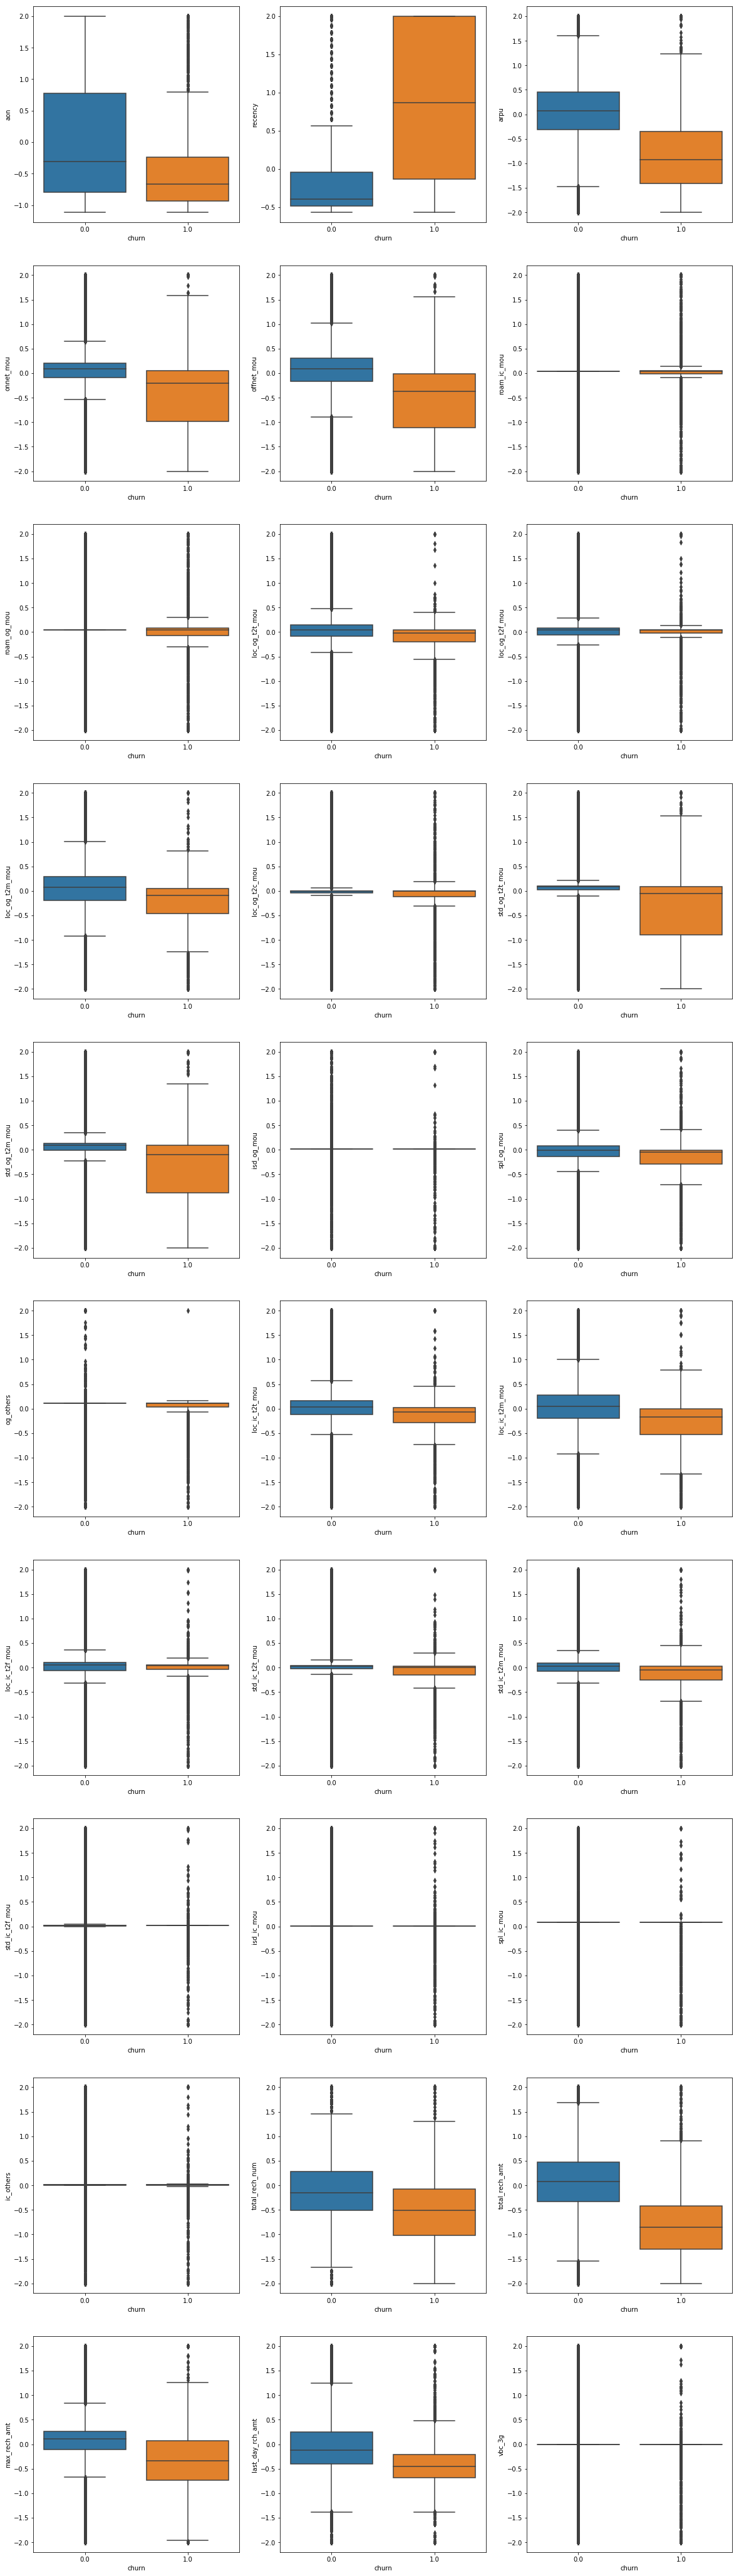

In [59]:
plt.figure(figsize=(20, 90))
plt.subplot(12, 3, 1)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.aon)

plt.subplot(12, 3, 2)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.recency)

plt.subplot(12, 3, 3)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.arpu)

plt.subplot(12, 3, 4)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.onnet_mou)

plt.subplot(12, 3, 5)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.offnet_mou)

plt.subplot(12, 3, 6)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.roam_ic_mou)

plt.subplot(12, 3, 7)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.roam_og_mou)

plt.subplot(12, 3, 8)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_og_t2t_mou)

plt.subplot(12, 3, 9)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_og_t2f_mou)

plt.subplot(12, 3, 10)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_og_t2m_mou)

plt.subplot(12, 3, 11)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_og_t2c_mou)

plt.subplot(12, 3, 12)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.std_og_t2t_mou)

plt.subplot(12, 3, 13)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.std_og_t2m_mou)

plt.subplot(12, 3, 14)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.isd_og_mou)

plt.subplot(12, 3, 15)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.spl_og_mou)

plt.subplot(12, 3, 16)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.og_others)

plt.subplot(12, 3, 17)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_ic_t2t_mou)

plt.subplot(12, 3, 18)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_ic_t2m_mou)

plt.subplot(12, 3, 19)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.loc_ic_t2f_mou)

plt.subplot(12, 3, 20)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.std_ic_t2t_mou)

plt.subplot(12, 3, 21)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.std_ic_t2m_mou)

plt.subplot(12, 3, 22)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.std_ic_t2f_mou)

plt.subplot(12, 3, 23)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.isd_ic_mou)

plt.subplot(12, 3, 24)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.spl_ic_mou)

plt.subplot(12, 3, 25)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.ic_others)

plt.subplot(12, 3, 26)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.total_rech_num)

plt.subplot(12, 3, 27)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.total_rech_amt)

plt.subplot(12, 3, 28)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.max_rech_amt)

plt.subplot(12, 3, 29)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.last_day_rch_amt)

plt.subplot(12, 3, 30)
sns.boxplot(x=df_eda_std.churn,y=df_eda_std.vbc_3g)

**The box plot shows the major variables  like aon, recency, arpu, onnet_mou, offnet_mou, show variation with churn.
We can also identify some of the variables like std_ic_t2f_mou, isd_ic_mou, spl_ic_mou, which have less impact on churn.**

### Part 2: Model Building - Logistic Regression

### 2.1 Split data into training and test sets and scale the data.

In [60]:
#train_test split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [61]:
y = df12.pop("churn")
X = df12

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100, train_size=0.7, test_size=0.3)

In [63]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train)) # New Dataframe for scaled X_train
X_train_scaled.columns = X_train.columns
X_test_scaled = pd.DataFrame(scaler.transform(X_test)) # New Dataframe for scaled X_test
X_test_scaled.columns = X_test.columns

In [64]:
X_train_scaled.head(10)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,Avgrechamt2mnths,recency,new_fb_user_6_Y,new_fb_user_7_Y,new_fb_user_8_Y,Data_User_6_Y,Data_User_7_Y,Data_User_8_Y,arpu_Y,onnet_mou_Y,offnet_mou_Y,roam_ic_mou_Y,roam_og_mou_Y,loc_og_t2t_mou_Y,loc_og_t2m_mou_Y,loc_og_t2f_mou_Y,loc_og_t2c_mou_Y,std_og_t2t_mou_Y,std_og_t2m_mou_Y,std_og_t2f_mou_Y,isd_og_mou_Y,spl_og_mou_Y,og_others_Y,loc_ic_t2t_mou_Y,loc_ic_t2m_mou_Y,loc_ic_t2f_mou_Y,std_ic_t2t_mou_Y,std_ic_t2m_mou_Y,std_ic_t2f_mou_Y,isd_ic_mou_Y,spl_ic_mou_Y,ic_others_Y,total_rech_num_Y,total_rech_amt_Y,max_rech_amt_Y,last_day_rch_amt_Y,max_rech_amt_Y,vol_2g_mb_Y,vol_3g_mb_Y,vbc_3g_Y,monthly_2g_Y,monthly_3g_Y,sachet_2g_Y,sachet_3g_Y
0,0.426579,0.362393,0.062954,-0.080196,-0.202345,-0.083514,-0.060297,-0.666840,-0.573568,-0.047578,-0.173214,-0.166713,-0.139208,-0.228325,-0.202317,-0.203208,0.068037,-0.009367,-0.442806,-0.574916,-0.452855,-0.296489,-0.208802,-0.075706,-0.220999,0.409032,-0.222253,0.032392,-0.247454,-0.070429,0.278444,-0.374606,-0.352051,-0.157911,-0.149362,-0.146069,-0.046837,-0.049434,-0.044731,-0.325195,-0.079145,-0.288334,-0.312771,-0.017207,-0.018804,-0.154462,0.004927,0.037646,-0.442656,-0.537080,-0.360820,-0.338054,-0.185234,-0.266390,-0.178188,-0.176666,-0.198723,-0.110533,-0.240698,-0.252450,-0.145021,-0.149527,-0.130119,-0.319856,-0.119105,-0.231077,-0.160880,-0.156210,-0.155358,-0.089070,-0.091728,-0.088971,-0.238069,-0.205552,-0.139109,0.407371,0.399674,0.136024,-0.092372,0.028059,-0.040329,0.120027,0.366917,-0.661149,0.028182,0.792572,0.397470,0.973991,1.183212,0.992426,0.208571,0.645750,0.686081,-0.295077,0.582537,-0.261873,0.357230,2.012437,1.218213,-0.286209,0.055115,0.406137,0.445289,2.677100,1.586745,-0.10368,-0.099325,-0.094777,2.356422,4.887878,5.353255,-0.296680,-0.309313,-0.332880,-0.295646,1.298963,-0.289765,-0.163192,-0.160262,-0.142395,1.098907,2.865319,2.316253,-0.203708,0.461313,0.040456,1.396134,1.383192,1.438864,1.374088,1.355165,1.401699,0.827841,0.816578,0.816006,0.384464,0.382565,-1.214855,-1.190193,-1.607865,0.476568,0.642897,0.736362,0.331548,0.223426,0.704684,0.068836,-1.175673,-1.12323,0.723274,0.639161,0.752446,0.435357,0.405310,0.273377,0.455145,-0.404505,0.793924,0.986995,

In [65]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(20780, 168)
(8907, 168)


In [66]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 2.2 Variable Selection Using RFE.
Note: suffix "_m1" to denote variables of model 1

In [67]:
# Importing RFE and LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [68]:
#Class Weight = We are using balanced class weight to counter the imbalanced class issue (91% of No Churn vs 9% of Churn)
#The “balanced” mode will automatically adjust weights in inverse proportion to respective class frequencies.

#Cost = 0.01: Smaller values specify stronger regularization. We tuned the model for several costs 
#and found 0.01 to give best results.

#Penalty: We found L1 penalty (Lasso) to provide better results  
#as L1 provides us with additional variable selection benefits in the presence of a large number of variables.

model_m1 = LogisticRegression(C=0.01, class_weight="balanced", dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

rfe_m1 = RFE(model_m1, 70)   # running RFE with 70 variables as output
rfe_m1 = rfe_m1.fit(X_train_scaled,y_train)
selected_vars_m1 = X.columns[rfe_m1.support_] # rfe_selected_vars contains the selected variables
print(list(selected_vars_m1))

['arpu_7', 'arpu_8', 'onnet_mou_6', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_8', 'std_og_t2m_mou_6', 'std_og_t2f_mou_7', 'og_others_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'spl_ic_mou_8', 'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'max_rech_amt_6', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_8', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_8', 'vol_2g_mb_8', 'vol_3g_mb_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'monthly_3g_8', 'sachet_3g_7', 'aon', 'recency', 'new_fb_user_8_Y', 'onnet_mou_Y', 'offnet_mou_Y', 'roam_ic_mou_Y', 'roam_og_mou_Y', 'loc_og_t2t_mou_Y', 'loc_og_t2m_mou_Y', 'loc_og_t2f_mou_Y', 'isd_og_mou_Y', 'loc_ic_t2t_mou_Y', 'loc_ic_t2m_mou_Y', '

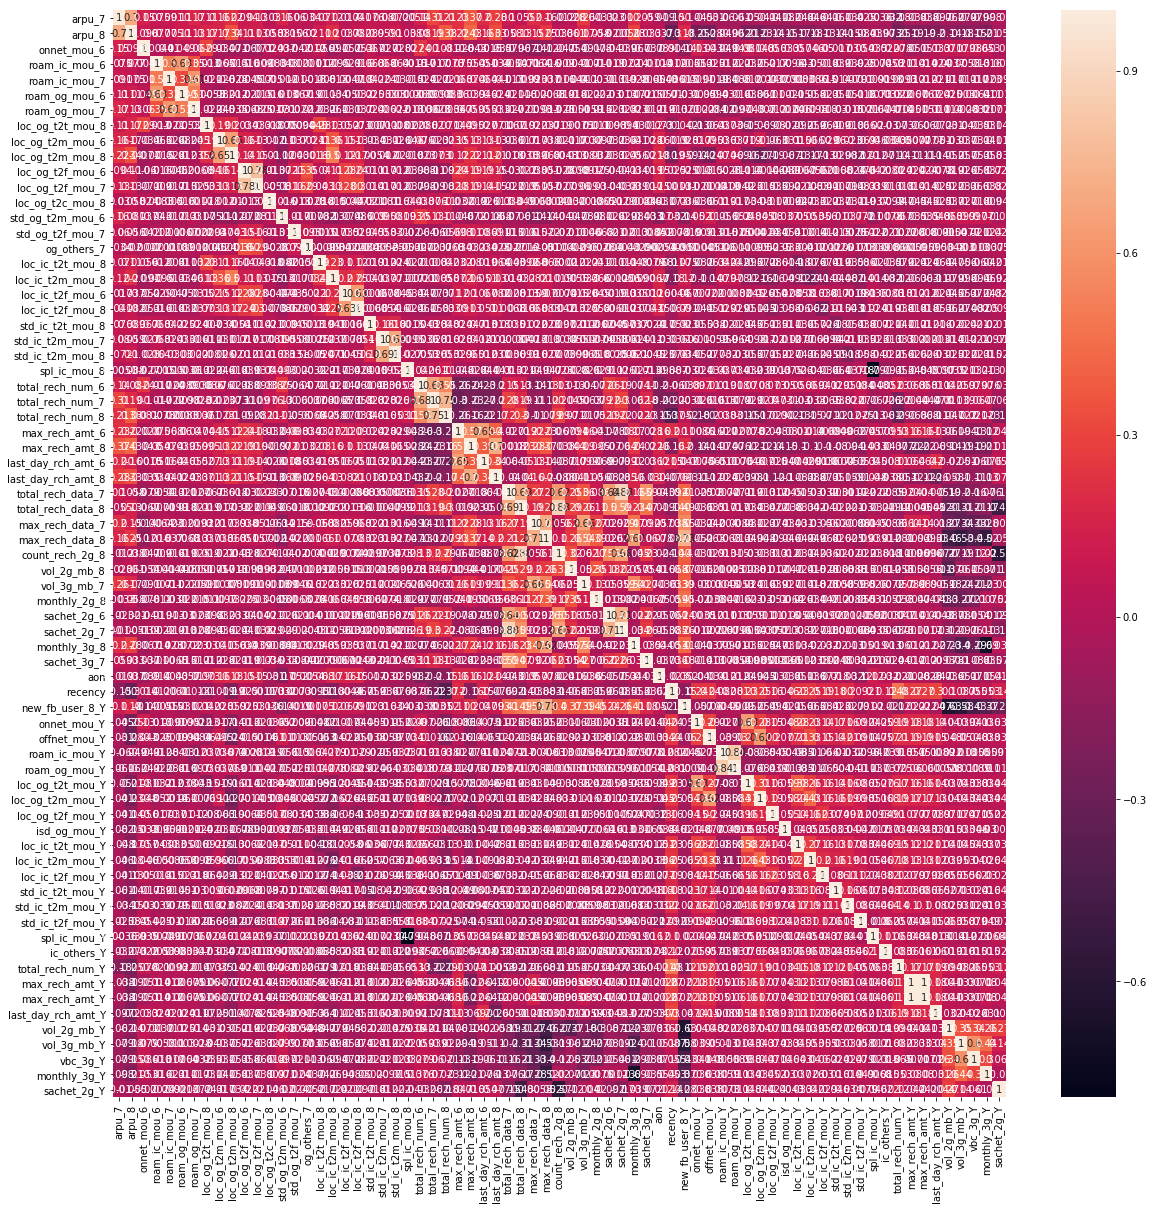

In [69]:
#Plotting the correlation matrix of the selected variables.
plt.figure(figsize = (20,20))
sns.heatmap(X_train_scaled[selected_vars_m1].corr(),annot = True)

We find that there are very few variables which have high correlation.<br>
This amount of correlation should not affect model prediction.

### 2.3 Model Training and Prediction

In [70]:
#fit the model with the RFE selected variables.
model_m1.fit(X_train_scaled[selected_vars_m1], y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [71]:
#Predict the Probability for the test data 

pred_df_m1 = pd.DataFrame(model_m1.predict_proba(X_test_scaled[selected_vars_m1]))
pred_df_m1 = pred_df_m1.iloc[:,[1]] # Adding churn probability
pred_df_m1.columns = ["churn_prob"]
pred_df_m1["y_test"] = y_test # Adding y_test

#As our class weights have already been adjusted by the algorithm, we can set the Probability Threshold for Churn to 0.5.
pred_df_m1['predicted'] = pred_df_m1.churn_prob.map(lambda x: 1 if x > 0.5 else 0) # Adding predicted churn from probability

In [72]:
pred_df_m1.head(10)

,churn_prob,y_test,predicted
0,0.527837,0,1
1,0.044516,0,0
2,0.201300,0,0
3,0.800786,1,1
4,0.164157,0,0
5,0.007178,0,0
6,0.248282,0,0
7,0.123570,0,0
8,0.121679,0,0
9,0.836346,0,1


### 2.4 Model Evaluation: Accuracy, Recall, Precision.

In [73]:
from sklearn import metrics
cm = metrics.confusion_matrix( pred_df_m1.y_test, pred_df_m1.predicted )
print(cm)

[[7093 1109]
 [  90  615]]


TP: 615<br>
TN: 7093

FP: 1109<br>
FN: 90 

In [74]:
print(metrics.classification_report(pred_df_m1.y_test, pred_df_m1.predicted, target_names=["not churn","churn"]))

print('Accuracy: ', np.round(metrics.accuracy_score(y_true=pred_df_m1.y_test, y_pred=pred_df_m1.predicted),2))

             precision    recall  f1-score   support

  not churn       0.99      0.86      0.92      8202
      churn       0.36      0.87      0.51       705

avg / total       0.94      0.87      0.89      8907

Accuracy:  0.87


The model is able to recall 87% of churners at probability threshold of 0.5.

The overall precision of the model is 0.94.

In [75]:
#If the threshold is changed the Recall and Sensitivity change in inverse proportion as shown in the table below.
#The ideal threshold should balance both Recall and Sensitivity and also depends on business requirements.

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
        pred_df_m1[i] = pred_df_m1.churn_prob.map( lambda x: 1 if x > i else 0)
pred_df_m1.head()

# Now let's calculate accuracy, sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( pred_df_m1.y_test, pred_df_m1[i] )
    total1=sum(sum(cm1))
    accuracy = np.float32(cm1[0,0]+cm1[1,1])/total1
    
    speci = np.float32(cm1[0,0])/(cm1[0,0]+cm1[0,1])
    sensi = np.float32(cm1[1,1])/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.079151  1.000000  0.000000
0.1   0.1  0.353205  0.987234  0.298708
0.2   0.2  0.595038  0.963121  0.563399
0.3   0.3  0.738296  0.934752  0.721409
0.4   0.4  0.821601  0.910638  0.813948
0.5   0.5  0.865387  0.872340  0.864789
0.6   0.6  0.889862  0.808511  0.896854
0.7   0.7  0.909285  0.729078  0.924774
0.8   0.8  0.924329  0.641135  0.948671
0.9   0.9  0.932862  0.448227  0.974518


### 2.5 Model Evaluation: ROC

In [76]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

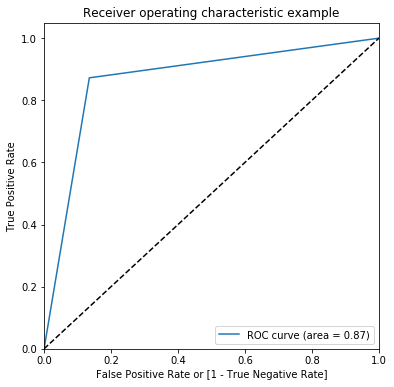

(array([0.        , 0.13521092, 1.        ]),
 array([0.        , 0.87234043, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [77]:
draw_roc(pred_df_m1.y_test, pred_df_m1.predicted)

**The Area under ROC curve value of 0.87 shows that model predictions are good and it does a far better job than a random classifier.**

### Model Evaluation: Precision-Recall Tradeoff

In [78]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, pred_df_m1.churn_prob)

print('Average precision-recall score RF: {}'.format(average_precision))

Average precision-recall score RF: 0.5469801926475641


Text(0.5,1,'2-class Precision-Recall curve: AP=0.55')

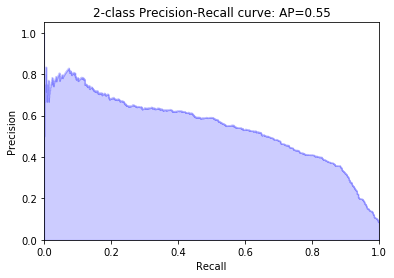

In [79]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, pred_df_m1.churn_prob)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_df_m1.churn_prob)
area = auc(recall, precision)
area

0.5456875406627664

Plot of the Precision-Recall curve shows us the tradeoff between Precision and Recall. 

We see an inverse relationship  between Precision and Recall. We observe that at 80% recall we get precision of 40%. 

The Probability Threshold of 0.5 can be adjusted in either direction to increase one metric at the cost of another.

### Model Evaluation: Cumulative Gain Chart

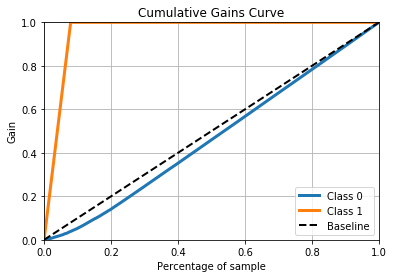

In [81]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_test, pred_df_m1)
plt.show()

**The Gains chart shows that the top decile of churn probabilities predicts 100% of the churn.**

### Part 3: Model Building - Logistic Regression with Cross Validation

### 3.1 Scale the data and do RFE

In [82]:
scaler_m2 = StandardScaler()

X_scaled_m2 = pd.DataFrame(scaler_m2.fit_transform(X))
X_scaled_m2.columns = X.columns
y_m2 = y.reset_index(drop=True)

In [83]:
logreg_m2 = LogisticRegression(C=0.01, class_weight="balanced", dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

rfe_m2 = RFE(logreg_m2, 50)  
rfe_m2 = rfe_m2.fit(X_scaled_m2,y_m2)
selected_vars_m2 = X.columns[rfe_m2.support_] # rfe_selected_vars contains the selected variables
print(list(selected_vars_m2))

['arpu_7', 'arpu_8', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'std_og_t2m_mou_7', 'isd_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2t_mou_8', 'ic_others_7', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8', 'last_day_rch_amt_6', 'last_day_rch_amt_8', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_8', 'av_rech_amt_data_6', 'vol_3g_mb_7', 'monthly_2g_8', 'sachet_2g_6', 'monthly_3g_6', 'monthly_3g_8', 'aon', 'recency', 'new_fb_user_8_Y', 'onnet_mou_Y', 'roam_ic_mou_Y', 'roam_og_mou_Y', 'loc_og_t2m_mou_Y', 'loc_og_t2f_mou_Y', 'isd_og_mou_Y', 'loc_ic_t2t_mou_Y', 'loc_ic_t2m_mou_Y', 'std_ic_t2t_mou_Y', 'std_ic_t2f_mou_Y', 'spl_ic_mou_Y', 'max_rech_amt_Y', 'last_day_rch_amt_Y', 'vol_3g_mb_Y', 'monthly_2g_Y']


### 3.2 Perform Logistic Regression with KFold

In [84]:
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

kf = KFold(n_splits=10, random_state=100)

In [85]:
def fn_churn(prob):
    if(prob > 0.5):
        return 1
    else:
        return 0

fn_churn = np.vectorize(fn_churn)

In [86]:
X_scaled_m2 = X_scaled_m2[selected_vars_m2]

for train_index, test_index in kf.split(X_scaled_m2.index):
    X_train_m2 = X_scaled_m2.iloc[train_index]
    X_test_m2 = X_scaled_m2.iloc[test_index]
    y_train_m2 = y_m2.iloc[train_index]
    y_test_m2 = y_m2.iloc[test_index]
    
    model_m2 = LogisticRegression(C=0.01, class_weight="balanced", dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
    model_m2.fit(X_train_m2, y_train_m2)
    
    pred_prob_m2 = model_m2.predict_proba(X_test_m2)[:,1]
    churn_m2 = fn_churn(pred_prob_m2)
    print("precision",precision_score(y_test_m2, churn_m2), "recall",recall_score(y_test_m2, churn_m2))

precision 0.38385502471169686 recall 0.8629629629629629
precision 0.34563758389261745 recall 0.8046875
precision 0.38204225352112675 recall 0.868
precision 0.3404255319148936 recall 0.8347826086956521
precision 0.40827338129496404 recall 0.88671875
precision 0.36379928315412186 recall 0.8252032520325203
precision 0.36283185840707965 recall 0.82
precision 0.3639705882352941 recall 0.825
precision 0.3642495784148398 recall 0.8372093023255814
precision 0.35901926444833626 recall 0.8686440677966102


**The KFold Cross Validation (K=10) shows the distribution of Precision vs Recall for different combinations of Train and Test Data.**

### Part 4: Model Building - Logistic Regression with PCA

### 4.1 Plotting features in PComponent Space

In [87]:
from sklearn.decomposition import PCA
pca_m3 = PCA(svd_solver='randomized', random_state=42)

In [88]:
#Doing the PCA on the Scaled Train data
pca_m3.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [89]:
#Verify the sample of variation captured in the first two Principal components
colnames = list(X_train_scaled.columns)
pcs_df_m3 = pd.DataFrame({'PC1':pca_m3.components_[0],'PC2':pca_m3.components_[1], 'Feature':colnames})
pcs_df_m3.head()

,PC1,PC2,Feature
0,0.055403,0.180115,arpu_6
1,0.069612,0.228641,arpu_7
2,0.079864,0.256310,arpu_8
3,-0.042029,0.068066,onnet_mou_6
4,-0.038548,0.096432,onnet_mou_7


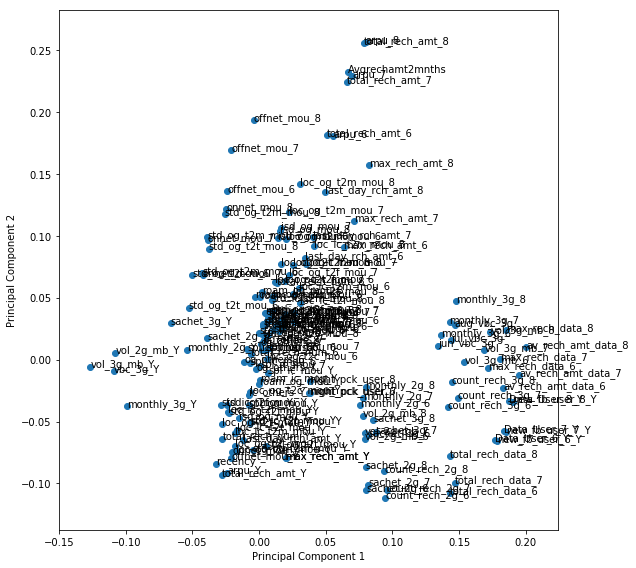

In [90]:
#Plotting the first two Principal components

%matplotlib inline
fig = plt.figure(figsize = (8,8))
plt.scatter(pcs_df_m3.PC1, pcs_df_m3.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df_m3.Feature):
    plt.annotate(txt, (pcs_df_m3.PC1[i],pcs_df_m3.PC2[i]))
plt.tight_layout()
plt.show()

We observe that the First Principal component has more loadings of Data usage attributes while<br>
The Second Principal component has more loadings of Monetary recharge attributes.

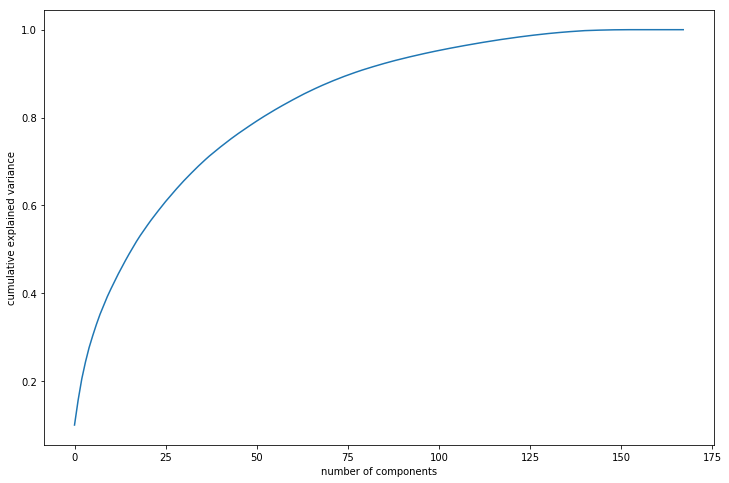

In [91]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca_m3.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [92]:
np.cumsum(pca_m3.explained_variance_ratio_)

array([0.10031472, 0.15726357, 0.20551693, 0.24354857, 0.27641584,
       0.30370243, 0.32910415, 0.35233547, 0.37278438, 0.39256783,
       0.41035316, 0.42742026, 0.44404984, 0.45983761, 0.47515574,
       0.48996809, 0.50413874, 0.51815232, 0.53111391, 0.54329593,
       0.55504563, 0.56660141, 0.57745726, 0.58821944, 0.59869958,
       0.60906785, 0.61878696, 0.62843384, 0.63801753, 0.64726064,
       0.65623236, 0.66489473, 0.67327371, 0.68155912, 0.68969716,
       0.69747585, 0.70510783, 0.7124827 , 0.71938365, 0.72624719,
       0.73287498, 0.73938056, 0.74579292, 0.75209349, 0.75819878,
       0.76409965, 0.76986124, 0.77554252, 0.78114991, 0.78670749,
       0.79217381, 0.79750384, 0.80272162, 0.80781511, 0.81281521,
       0.81773025, 0.8225575 , 0.82724935, 0.83186612, 0.83642316,
       0.84092905, 0.84535153, 0.84969208, 0.8540108 , 0.8580487 ,
       0.86201824, 0.86594361, 0.86976011, 0.87346543, 0.87706355,
       0.88058288, 0.88399956, 0.88734598, 0.89057492, 0.89376

**Note: We achieve 88% variability with 70 Principal components.**

In [93]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_m3 = IncrementalPCA(n_components=70)

**Basis transformation - getting the data onto our PCs**

In [94]:
df_train_pca = pd.DataFrame(pca_m3.fit_transform(X_train_scaled))
df_test_pca = pd.DataFrame(pca_m3.transform(X_test_scaled))

In [95]:
df_test_pca.shape

(8907, 70)

### 4.2 Model Training and Prediction 

In [96]:
model_m3 = LogisticRegression(C=0.01, class_weight="balanced", dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=100, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
#Fit the Logistic Regression model on the PCA data
model_m3.fit(df_train_pca, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [98]:
pred_df_m3 = pd.DataFrame(model_m3.predict_proba(df_test_pca))
pred_df_m3 = pred_df_m3.iloc[:,[1]] # Adding churn probability
pred_df_m3.columns = ["churn_prob"]
pred_df_m3["y_test"] = y_test # Adding y_test
pred_df_m3['predicted'] = pred_df_m3.churn_prob.map( lambda x: 1 if x > 0.5 else 0) # Adding predicted churn from probability

In [99]:
pred_df_m3.head()

,churn_prob,y_test,predicted
0,0.623845,0,1
1,0.075096,0,0
2,0.200761,0,0
3,0.798018,1,1
4,0.151141,0,0


### 4.3 Model Evaluation: Accuracy, Recall, Precision

In [100]:
from sklearn import metrics
cm_m3 = metrics.confusion_matrix(pred_df_m3.y_test, pred_df_m3.predicted)
print(cm_m3)

[[6933 1269]
 [  98  607]]


In [101]:
print(metrics.classification_report(pred_df_m3.y_test, pred_df_m3.predicted, target_names=["not churn","churn"]))

print('Accuracy: ', np.round(metrics.accuracy_score(y_true=pred_df_m3.y_test, y_pred=pred_df_m3.predicted),2))

             precision    recall  f1-score   support

  not churn       0.99      0.85      0.91      8202
      churn       0.32      0.86      0.47       705

avg / total       0.93      0.85      0.88      8907

Accuracy:  0.85


The model is able to recall 86% of churners at probability threshold of 0.5.

The overall precision of the model is 0.93.

We observe that there is not much difference in the RFE and PCA based Logistic Regression models.

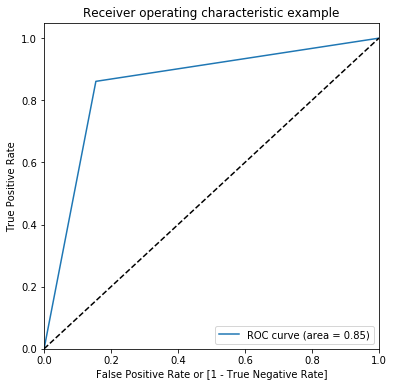

(array([0.        , 0.15471836, 1.        ]),
 array([0.        , 0.86099291, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [102]:
draw_roc(pred_df_m3.y_test, pred_df_m3.predicted)

**The Area under ROC curve value of 0.85 shows that model predictions are good and it does a far better job than a random classifier.**

## Part 5: Model Building - SVM Linear with PCA

### 5.1 Model Training and Prediction
***Note***: It took 2.5 min to train the model

In [103]:
#We are using the SVM Linear Model on the PCA data.

from sklearn import svm
model_m4 = svm.SVC(kernel="linear", class_weight="balanced", random_state=100)
model_m4.fit(df_train_pca, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False)

In [104]:
#Make predictions on test data using the model built.

predictions_m4 = model_m4.predict(df_test_pca)

### 5.2 Model Evaluation: Accuracy, Recall, Precision

In [105]:
cm_m4 = metrics.confusion_matrix( y_test, predictions_m4 )
print(cm_m4)

[[7053 1149]
 [ 102  603]]


In [106]:
print(metrics.classification_report(y_test, predictions_m4, target_names=["not churn","churn"]))
print('Accuracy: ', np.round(metrics.accuracy_score(y_true=y_test, y_pred=predictions_m4),2))

             precision    recall  f1-score   support

  not churn       0.99      0.86      0.92      8202
      churn       0.34      0.86      0.49       705

avg / total       0.93      0.86      0.88      8907

Accuracy:  0.86


The model is able to recall 86% of churners.

The overall precision of the model is 0.93.

We observe that PCA based SVM model performs similar to the other models we have built.

## Part 6: Model Building - SVM RBF with PCA with GridSearch 

### 6.1 Model Training
***Note***: It took 9.5 min to train the model

In [107]:
from sklearn.model_selection import GridSearchCV

In [108]:
parameters = {'C':[1, 10, 100], 
             'gamma': [1e-2, 1e-3, 1e-4]}

In [109]:
#This SVM model is considering Non Linear kernel for modelling.
#We are evaluating this on multiple levels of non-linearity by tweaking the Gamma parameter.

#The model is also evaluated on multiple Penalty parameter C for error terms.

#The GridSearch Scoring is done on the Recall metric, as it is the key parameter in this case of class imbalance.

model_m5 = svm.SVC(kernel="rbf", class_weight="balanced", random_state=100)
model_m5_clf = GridSearchCV(model_m5, param_grid=parameters, scoring='recall')
model_m5_clf.fit(df_train_pca, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=100, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100], 'gamma': [0.01, 0.001, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

### 6.2 Model Evaluation

In [110]:
#Evaluating the Cross Validation Results

cv_results = pd.DataFrame(model_m5_clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,14.752469,0.324085,4.603222,0.072618,1,0.01,"{'C': 1, 'gamma': 0.01}",0.746644,0.753356,0.751261,0.750420,0.002804,7,0.963896,0.963056,0.968121,0.965024,0.002216
1,15.539554,0.325204,4.825491,0.051968,1,0.001,"{'C': 1, 'gamma': 0.001}",0.807047,0.840604,0.808403,0.818685,0.015509,4,0.856423,0.846348,0.851510,0.851427,0.004114
2,18.925012,0.275423,5.851864,0.063155,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.807047,0.840604,0.813445,0.820366,0.014548,3,0.831234,0.820319,0.829698,0.827084,0.004824
3,11.825364,0.102970,3.498642,0.035020,10,0.01,"{'C': 10, 'gamma': 0.01}",0.635906,0.637584,0.630252,0.634581,0.003136,8,1.000000,1.000000,1.000000,1.000000,0.000000
4,14.181816,0.168687,4.245067,0.047807,10,0.001,"{'C': 10, 'gamma': 0.001}",0.803691,0.828859,0.816807,0.816452,0.010278,5,0.899244,0.893367,0.901007,0.897873,0.003266
5,15.934270,0.156156,4.842745,0.040364,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.813758,0.842282,0.818487,0.824843,0.012482,1,0.842149,0.829555,0.838926,0.836877,0.005342
6,12.207785,0.330683,2.976899,0.043224,100,0.01,"{'C': 100, 'gamma': 0.01}",0.530201,0.550336,0.534454,0.538330,0.008665,9,1.000000,1.000000,1.000000,1.000000,0.000000
7,16.150085,0.294257,3.576142,0.113030,100,0.001,"{'C': 100, 'gamma': 0.001}",0.748322,0.766779,0.766387,0.760495,0.008610,6,0.965575,0.967254,0.972315,0.968382,0.002865
8,16.050561,0.277136,4.719073,0.200076,100,0.0001,"{'C': 100, 'gamma': 0.0001}",0.807047,0.835570,0.818487,0.820368,0.011721,2,0.863140,0.851385,0.851510,0.855345,0.005512


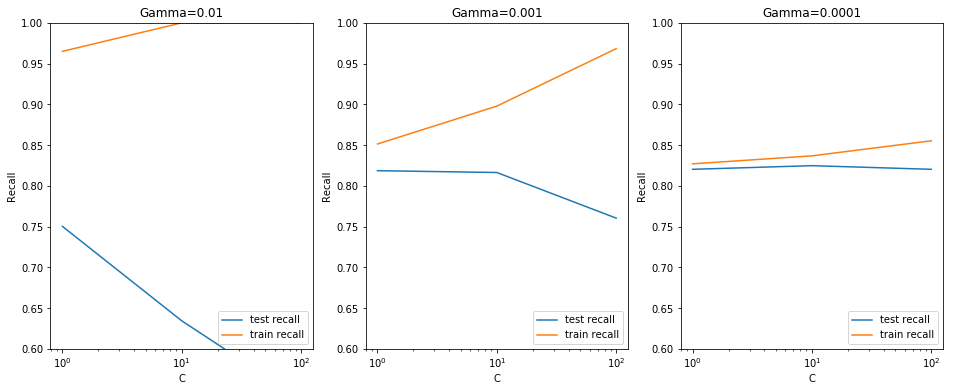

In [111]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Recall')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test recall', 'train recall'], loc='lower right')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Recall')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test recall', 'train recall'], loc='lower right')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Recall')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test recall', 'train recall'], loc='lower right')
plt.xscale('log')

plt.show()

**We observe that the higher values of Gamma lead to overfitting as evident from the first two graphs where the training and test data performance on recall, diverge to a great extent.**

The least value of gamma of 0.0001 indicates the low level of non-linearity implicit in the data provided.

The last graph offers the ideal classifier at the ***Cost of C=10 and Gamma=0.0001.***

In [112]:
print("The best parameter estimates are "+str(model_m5_clf.best_params_))

The best parameter estimates are {'C': 10, 'gamma': 0.0001}


In [113]:
predictions_m5 = model_m5_clf.predict(df_test_pca)

In [114]:
cm_m5 = metrics.confusion_matrix( y_test, predictions_m5 )
print(cm_m5)

[[7075 1127]
 [ 104  601]]


In [115]:
print(metrics.classification_report(y_test, predictions_m5, target_names=["not churn","churn"]))
print('Accuracy: ', np.round(metrics.accuracy_score(y_true=y_test, y_pred=predictions_m5),2))

             precision    recall  f1-score   support

  not churn       0.99      0.86      0.92      8202
      churn       0.35      0.85      0.49       705

avg / total       0.94      0.86      0.89      8907

Accuracy:  0.86


The model is able to recall 85% of churners.

The overall precision of the model is 0.94.

We observe that PCA based RBF-SVM model with low values of Gamma also performs similar to the other models we have built.

This indicates a linear relationship between the predictors and the output variable.

## Part 7: Conclusion Summary

In [116]:
datetime.datetime.now()

datetime.datetime(2018, 12, 23, 17, 48, 30, 632827)

### We have analyzed the following models and all of them result in similar levels of Accuracy, Recall and Precision.

Model Building - Logistic Regression<br>
Threshold For Churn: 0.5<br>
Model Accuracy: 0.87<br>
Churn Recall: 0.87<br>
Churn Precision: 0.36<br>

The Probability Threshold for Churn can be adjusted as per business requirements to increase the Recall or the Precision required.<br>

Threshold   |   accuracy    |    sensitivity  |   specificity<br>
0.4         |   0.821601    |    0.910638     |    0.813948<br>
0.5         |   0.865387    |    0.872340     |    0.864789<br>
0.6         |   0.889862    |    0.808511     |    0.896854<br>
0.7         |   0.909285    |    0.729078     |    0.924774<br>

Model Building - Logistic Regression with Cross Validation<br>

precision 0.38     |      recall 0.86<br>
precision 0.35     |      recall 0.80<br>
precision 0.38     |      recall 0.87<br>
precision 0.34     |      recall 0.83<br>
precision 0.41     |      recall 0.89<br>
precision 0.36     |      recall 0.83<br>
precision 0.36     |      recall 0.82<br>
precision 0.36     |      recall 0.83<br>
precision 0.36     |      recall 0.84<br>
precision 0.36     |      recall 0.87<br>

Model Building - Logistic Regression with PCA<br>
Model Accuracy: 0.85<br>
Churn Recall: 0.86<br>
Churn Precision: 0.32<br>

Model Building - SVM Linear<br>
Model Accuracy: 0.86<br>
Churn Recall: 0.86<br>
Churn Precision: 0.34<br>

Model Building - SVM RBF with GridSearch<br>
Model Accuracy: 0.86<br>
Churn Recall: 0.85<br>
Churn Precision: 0.35<br>